# Chile Climate Risk Analysis on Copper Price

#### Research Questions / Hypotheses:
We hypothesize that climate and economic conditions in Chile have a measurable impact on copper production. Specifically, we investigate how El Niño events (as captured by the Oceanic Niño Index (ONI)), annual temperature, precipitation, inflation, and GDP growth in Chile correlate with variations in national copper output.


We further hypothesize that changes in global copper production and demand influence global copper prices. Given Chile’s position as the world’s largest copper producer, production shifts—especially those driven by climate and macroeconomic shocks—may contribute to observable movements in international copper markets.
Major Data sets:
USGS
NOAA
CMIP6

## I. Copper Production

### IA. Global Copper Production

/tmp/ipykernel_121/2236578978.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid
/tmp/ipykernel_121/2236578978.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Pastel1', len(merged))


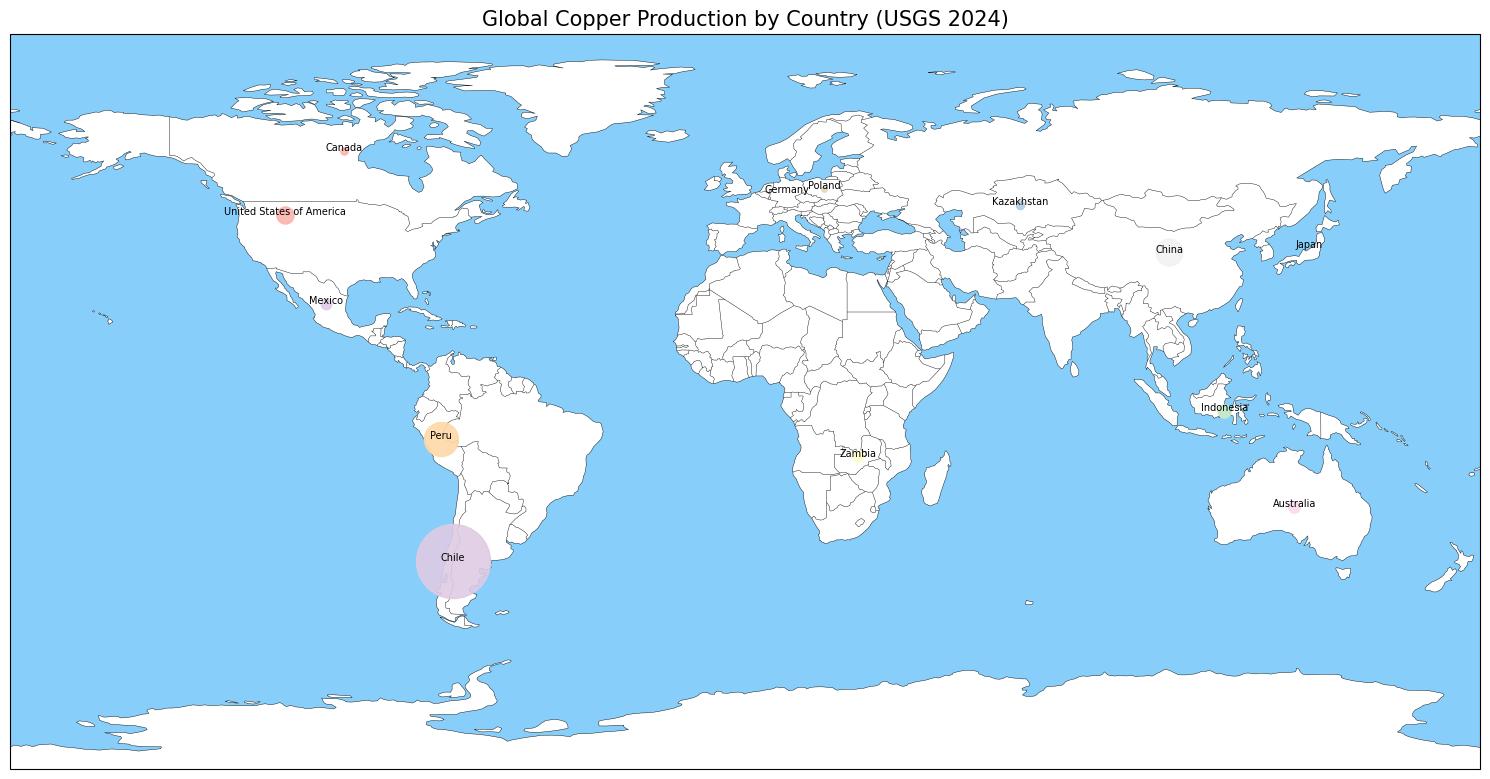

In [88]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# Step 1: Load copper production CSV
url = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/mcs2024-copper_world.csv"
df = pd.read_csv(url)

# Step 2: Clean & fix country names
df = df.rename(columns={'Prod_kt_2022': 'Production_kt'})
df['Production_kt'] = pd.to_numeric(df['Production_kt'], errors='coerce')
df['Country'] = df['Country'].replace({
    'United States': 'United States of America',
    'Russia': 'Russian Federation',
    'Iran': 'Iran (Islamic Republic of)',
    'Vietnam': 'Viet Nam',
    'Syria': 'Syrian Arab Republic',
    'South Korea': 'Republic of Korea',
    'North Korea': 'Dem. Rep. Korea',
    'Czech Republic': 'Czechia',
    'DR Congo': 'Democratic Republic of the Congo'
})

# Step 3: Load world map
shapefile = natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
world = gpd.read_file(shapefile)

# Step 4: Merge data
merged = world.merge(df, how='left', left_on='NAME', right_on='Country')
merged = merged.dropna(subset=['Production_kt']).reset_index(drop=True)

# Step 5: Compute centroids
merged['centroid'] = merged.geometry.centroid

# Step 6: Set up map
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='lightskyblue')
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

# Step 7: Assign unique pastel color per country
colors = cm.get_cmap('Pastel1', len(merged))
for idx, row in merged.iterrows():
    color = colors(idx % colors.N)
    ax.plot(row['centroid'].x, row['centroid'].y,
            marker='o',
            markersize=row['Production_kt'] / 100,
            color=color,
            alpha=0.9,
            transform=ccrs.PlateCarree())
    ax.text(row['centroid'].x, row['centroid'].y, row['Country'],
            fontsize=7, ha='center', transform=ccrs.PlateCarree())

# Final styling
plt.title("Global Copper Production by Country (USGS 2024)", fontsize=15)
plt.tight_layout()
plt.show()


### IB. Chile's Copper Import and Export

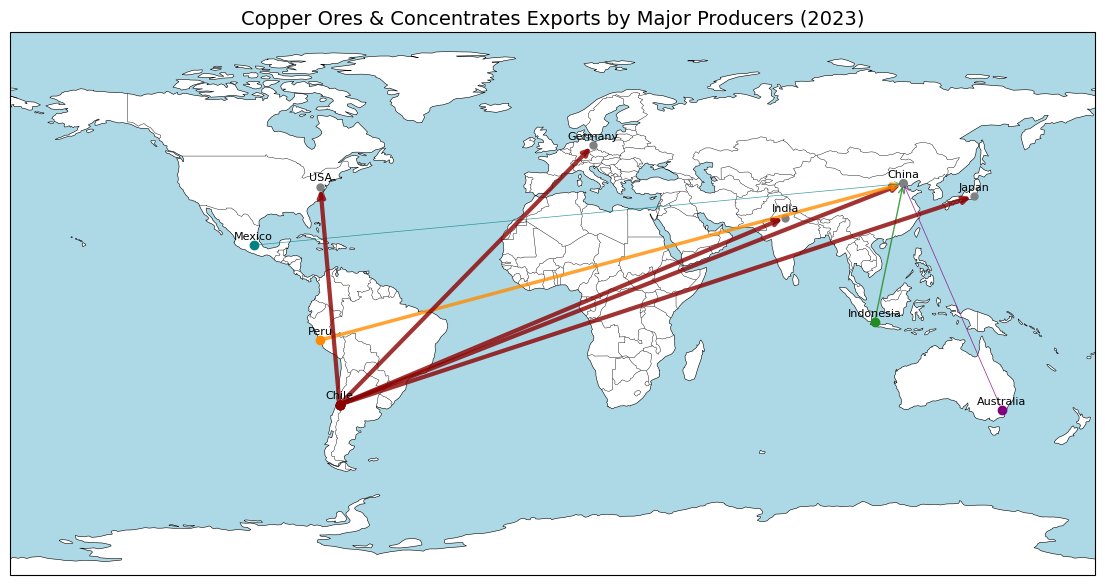

In [89]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Top exporters (~2023 USD billions)
exporters = {
    'Chile': 24.3,
    'Peru': 19.99,
    'Indonesia': 8.33,
    'Australia': 4.34,
    'Mexico': 3.72
}

# Selected export flows only
flows = [
    ('Chile', 'China'),
    ('Peru', 'China'),
    ('Indonesia', 'China'),
    ('Australia', 'China'),
    ('Mexico', 'China'),
    ('Chile', 'Japan'),
    ('Chile', 'Germany'),
    ('Chile', 'India'),
    ('Chile', 'USA')
]

# Approximate lat/lon for capitals
coords = {
    'Chile': (-33.45, -70.66),
    'Peru': (-12.04, -77.03),
    'Indonesia': (-6.21, 106.85),
    'Australia': (-35.28, 149.13),
    'Mexico': (19.43, -99.13),
    'China': (39.90, 116.40),
    'Japan': (35.68, 139.76),
    'Germany': (52.52, 13.40),
    'India': (28.61, 77.21),
    'USA': (38.90, -77.04)
}

# Define custom colors for each exporter
export_colors = {
    'Chile': 'darkred',
    'Peru': 'darkorange',
    'Indonesia': 'forestgreen',
    'Australia': 'purple',
    'Mexico': 'teal'
}

# Setup map
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Plot only exports with unique colors per country
for exp, imp in flows:
    elat, elon = coords[exp]
    ilat, ilon = coords[imp]
    val = exporters.get(exp, 1)
    color = export_colors.get(exp, 'red')  # fallback color

    ax.annotate(
        '', xy=(ilon, ilat), xytext=(elon, elat),
        xycoords=ccrs.Geodetic()._as_mpl_transform(ax),
        textcoords=ccrs.Geodetic()._as_mpl_transform(ax),
        arrowprops=dict(arrowstyle='->', color=color, linewidth=val/8, alpha=0.8)
    )

    # Plot exporter dot
    ax.plot(elon, elat, 'o', color=color, transform=ccrs.PlateCarree(), markersize=6)
    # Plot importer dot (gray)
    ax.plot(ilon, ilat, 'o', color='gray', transform=ccrs.PlateCarree(), markersize=5)

# Add labels for countries
for country, (lat, lon) in coords.items():
    ax.text(lon, lat + 2, country, fontsize=8, ha='center', transform=ccrs.PlateCarree())

plt.title("Copper Ores & Concentrates Exports by Major Producers (2023)", fontsize=14)
plt.show()

### IB. Major mines in Chile

In [90]:
import folium

# Define the mines dictionary explicitly
mines = {
    'Escondida Mine': (-24.2687, -69.0685),
    'Chuquicamata Mine': (-22.2985, -68.9019),
    'El Teniente Mine': (-34.0875, -70.3894),
    'Collahuasi Mine': (-20.9975, -68.6789),
    'Los Pelambres Mine': (-31.7253, -70.4928)
}

# Initialize Chile map centered in the north-central region
m = folium.Map(location=[-27, -70], zoom_start=5)

# Add mines as markers
for name, (lat, lon) in mines.items():
    folium.Marker(
        location=[lat, lon],
        popup=name,
        icon=folium.Icon(color='red', icon='industry', prefix='fa')
    ).add_to(m)

m.save("chile_mines_map.html")

m

## II. Climate Risk Variables

## IIA. ENSO 


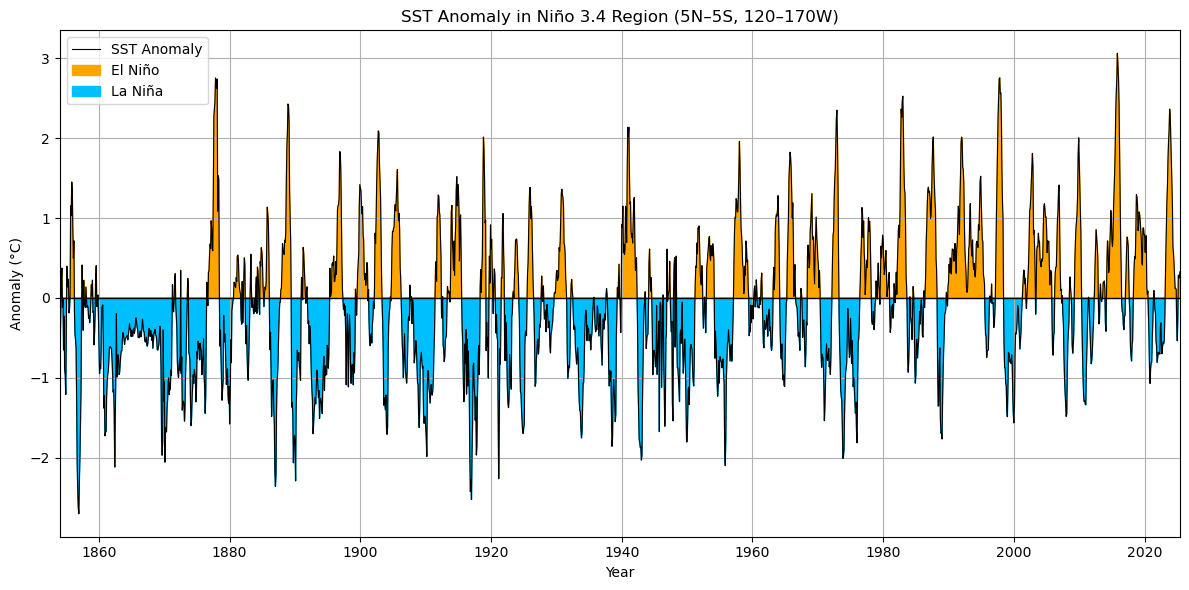

In [91]:
import xarray as xr
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_nino = xr.open_dataset(url, drop_variables=['time_bnds'])
ds_nino_sel = ds_nino.sel(time=slice('1900', '2020')).load()
ds_nino_sel


# Compute anomalies
nino34 = ds_nino['sst'].sel(lat=slice(5, -5), lon=slice(190, 240))
nino34_mean = nino34.mean(dim=['lat', 'lon'], skipna=True)
clim = nino34_mean.sel(time=slice('1951', '1980')).groupby('time.month').mean('time')
anomalies = nino34_mean.groupby('time.month') - clim

# Plot
plt.figure(figsize=(12, 6))
plt.plot(anomalies['time'], anomalies, color='black', linewidth=0.8, label='SST Anomaly')

# Fill above and below zero
plt.fill_between(anomalies['time'], 0, anomalies,
                 where=anomalies >= 0, color='orange', label='El Niño', interpolate=True)

plt.fill_between(anomalies['time'], 0, anomalies,
                 where=anomalies < 0, color='deepskyblue', label='La Niña', interpolate=True)

# Styling
plt.axhline(0, color='black', linewidth=1)
plt.title('SST Anomaly in Niño 3.4 Region (5N–5S, 120–170W)')
plt.ylabel('Anomaly (°C)')
plt.xlabel('Year')
plt.grid(True)

# Remove whitespace
plt.xlim(anomalies['time'].values[0], anomalies['time'].values[-1])

plt.legend()
plt.tight_layout()
plt.show()


# 1982 El Niño vs. 1999 La Niña

# Compute monthly climatology from 1951–1980 (baseline)
clim = ds_nino['sst'].sel(time=slice('1951', '1980')).groupby('time.month').mean('time')

# Select full-year data for 1982 and 1999
sst_1982 = ds_nino['sst'].sel(time=slice('1982-01-01', '1982-12-31'))
sst_1999 = ds_nino['sst'].sel(time=slice('1999-01-01', '1999-12-31'))

# Compute monthly anomalies
anom_1982 = sst_1982.groupby('time.month') - clim
anom_1999 = sst_1999.groupby('time.month') - clim

# Compute annual mean anomalies
anom_1982_annual = anom_1982.mean(dim='time')
anom_1999_annual = anom_1999.mean(dim='time')

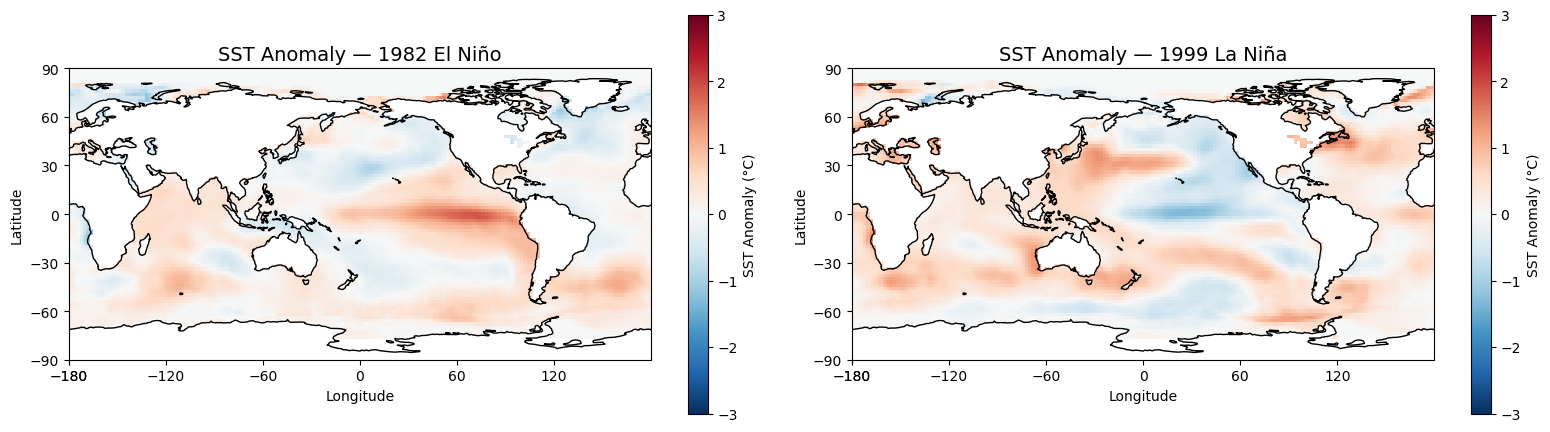

In [92]:
# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define common plot settings
vmin, vmax = -3, 3
cmap = 'RdBu_r'
xticks = range(0, 361, 60)
yticks = range(-90, 91, 30)

# Plot El Niño 1982
plot1 = anom_1982_annual.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={'label': 'SST Anomaly (°C)', 'shrink': 0.7}
)
axes[0].set_title("SST Anomaly — 1982 El Niño", fontsize=14)
axes[0].coastlines()
axes[0].set_xticks(xticks, crs=ccrs.PlateCarree())
axes[0].set_yticks(yticks, crs=ccrs.PlateCarree())
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Plot La Niña 1999
plot2 = anom_1999_annual.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={'label': 'SST Anomaly (°C)', 'shrink': 0.7}
)
axes[1].set_title("SST Anomaly — 1999 La Niña", fontsize=14)
axes[1].coastlines()
axes[1].set_xticks(xticks, crs=ccrs.PlateCarree())
axes[1].set_yticks(yticks, crs=ccrs.PlateCarree())
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# Layout
plt.tight_layout()
plt.show()

## IIB. Temperature Variation


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


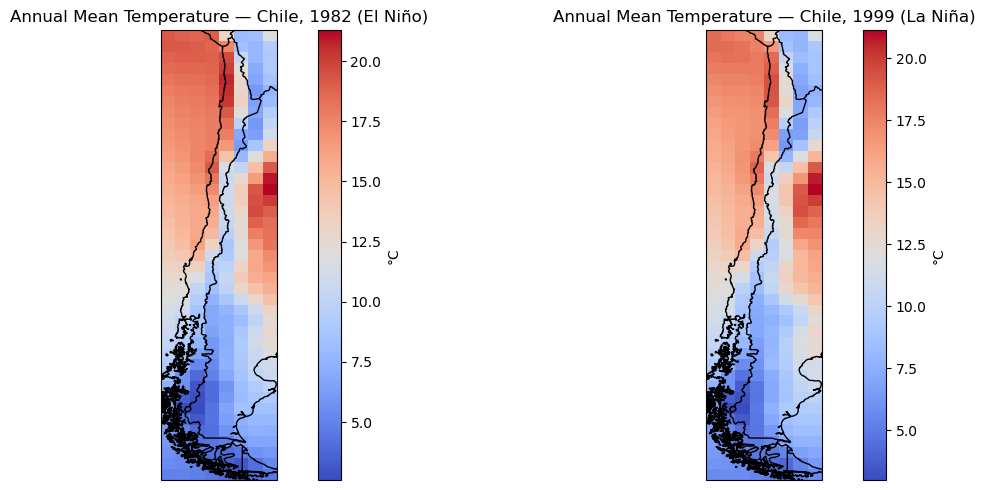

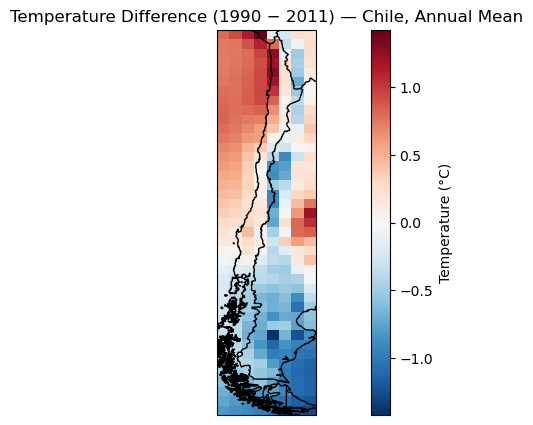

In [93]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import matplotlib.pyplot as plt

col = google_cmip_col()
col

# Search for temperature data
cat_tas = col.search(
    source_id='CESM2',
    variable_id='tas',          # tas = near-surface air temperature
    table_id='Amon',
    experiment_id='historical',
    member_id='r1i1p1f1',
)

# Load temp dataset
ds_dict_tas = cat_tas.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
ds_tas = list(ds_dict_tas.values())[0]

# Long Lat for Chile
lat_chile = slice(-56, -17)                      # 5S to 5N
lon_chile = slice(284, 294)                      # 66W to 76W (0–360)


# Select annual temperature data
ds_tas_1982 = ds_tas['tas'].sel(time=slice('1982-01-01', '1982-12-31'), lat=lat_chile, lon=lon_chile)
ds_tas_1999 = ds_tas['tas'].sel(time=slice('1999-01-01', '1999-12-31'), lat=lat_chile, lon=lon_chile)

# Convert to Celsius and average over year
tas_1982 = ds_tas_1982.isel(member_id=0, dcpp_init_year=0) - 273.15
tas_1999 = ds_tas_1999.isel(member_id=0, dcpp_init_year=0) - 273.15

tas_1982_mean = tas_1982.mean(dim='time')
tas_1999_mean = tas_1999.mean(dim='time')

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 1982
tas_1982_mean.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='coolwarm',
                   cbar_kwargs={'label': '°C'})
axes[0].set_title('Annual Mean Temperature — Chile, 1982 (El Niño)')
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS, linewidth=1)

# 1999
tas_1999_mean.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='coolwarm',
                   cbar_kwargs={'label': '°C'})
axes[1].set_title('Annual Mean Temperature — Chile, 1999 (La Niña)')
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS, linewidth=1)

plt.tight_layout()
plt.show()

# Compute difference (°C)
tas_diff = tas_1982_mean - tas_1999_mean

# Plot difference
plt.figure(figsize=(14, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
tas_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', center=0,
              cbar_kwargs={'label': 'Temperature (°C)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.set_title('Temperature Difference (1990 − 2011) — Chile, Annual Mean')
plt.show()


## IIC. Precipitation Variation



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


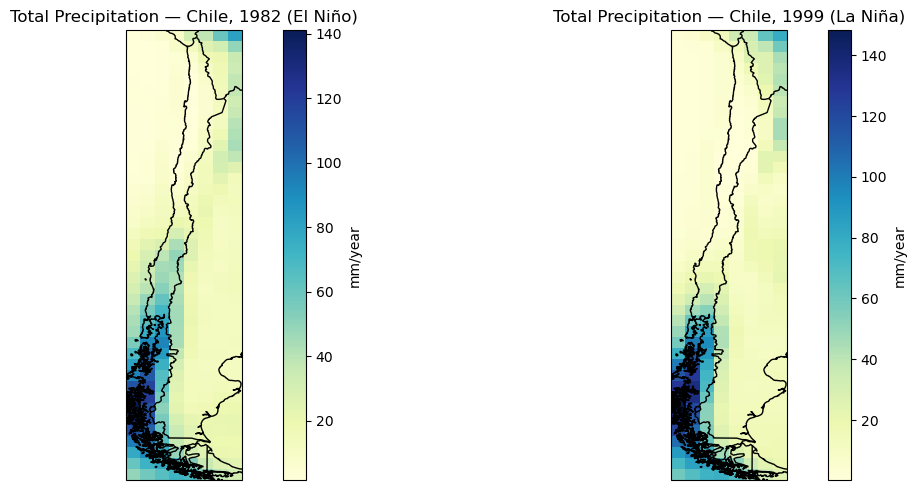

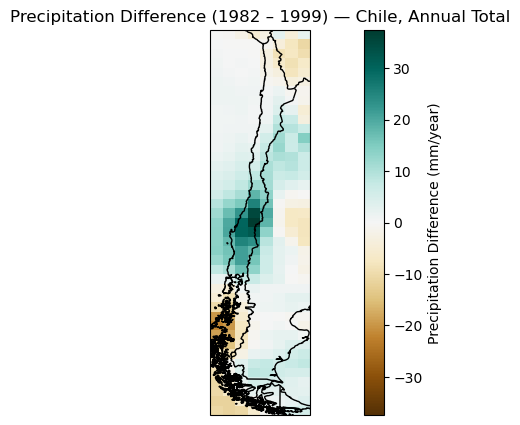

In [94]:
# Search for precipitation data
cat = col.search(
    source_id='CESM2',
    variable_id='pr',
    table_id='Amon',
    experiment_id='historical',
    member_id='r1i1p1f1',
)

# Load precip dataset
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
ds = list(ds_dict.values())[0]
ds

# Select annual periods for 1982 and 1999
ds_pr_1982 = ds['pr'].sel(time=slice('1982-01-01', '1982-12-31'), lat=lat_chile, lon=lon_chile)
ds_pr_1999 = ds['pr'].sel(time=slice('1999-01-01', '1999-12-31'), lat=lat_chile, lon=lon_chile)

# Convert to mm/year (from kg/m²/s = mm/s)
pr_1982_annual = ds_pr_1982.isel(member_id=0, dcpp_init_year=0) * 86400  # mm/day
pr_1999_annual = ds_pr_1999.isel(member_id=0, dcpp_init_year=0) * 86400

pr_1982_total = pr_1982_annual.sum(dim='time')
pr_1999_total = pr_1999_annual.sum(dim='time')

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 1982 — El Niño
pr_1982_total.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='YlGnBu',
                   cbar_kwargs={'label': 'mm/year'})
axes[0].set_title('Total Precipitation — Chile, 1982 (El Niño)')
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS, linewidth=1)

# 1999 — La Niña
pr_1999_total.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='YlGnBu',
                   cbar_kwargs={'label': 'mm/year'})
axes[1].set_title('Total Precipitation — Chile, 1999 (La Niña)')
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS, linewidth=1)

plt.tight_layout()
plt.show()


# Compute difference: El Niño − La Niña
pr_diff = pr_1982_total - pr_1999_total

# Plot difference map
plt.figure(figsize=(14, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
pr_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', center=0,
             cbar_kwargs={'label': 'Precipitation Difference (mm/year)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.set_title('Precipitation Difference (1982 – 1999) — Chile, Annual Total')
plt.show()



### III. Regression Analysis

In [95]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load all raw data
precip_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/precipitation-annual-tre.csv"
correct_temp_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/average-mean-surface-air.csv"
oni_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/Monthly%20Oceanic%20Nino%20Index%20(ONI)%20-%20Wide.csv"
copper_price_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/Daily%20Copper%20Price.xlsx"

#### IIIA: Data Cleaning

In [97]:
# Step 2: Clean precipitation data
def read_and_clean_climate_data(file_path, value_name):
    raw = pd.read_csv(file_path, sep=';', header=None)
    df = raw.copy().iloc[1:]
    df.columns = ['Year', 'CodeValue']
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Value'] = df['CodeValue'].astype(str).str.split(',').str[-1]
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df = df[['Year', 'Value']].dropna()
    df = df.rename(columns={'Value': value_name})
    return df

correct_precip_df = pd.read_csv(precip_path)
precip_clean = correct_precip_df[['Year', 'Annual Precipitation']].rename(
    columns={'Annual Precipitation': 'Precipitation'}
).dropna()
correct_precip_df

,Year,Annual Precipitation,Trend 1951-2020,Trend 1971-2020,Trend 1991-2020
0,1950,1599.28,NaN,NaN,NaN
1,1951,1620.59,1451.140487,NaN,NaN
2,1952,1308.84,1452.423359,NaN,NaN
3,1953,1626.74,1453.706231,NaN,NaN
4,1954,1660.37,1454.989103,NaN,NaN
...,...,...,...,...,...
69,2019,1451.85,1538.375784,1520.840746,1520.718194
70,2020,1486.43,1539.658656,1520.932165,1521.175591
71,2021,1297.33,NaN,NaN,NaN
72,2022,1414.47,NaN,NaN,NaN


In [99]:
# Step 3: Clean copper price (daily to annual)
copper_df = pd.read_excel(copper_price_path, engine="openpyxl")
date_col = copper_df['Date']
is_numeric = pd.to_numeric(date_col, errors='coerce').notnull()

copper_df['Parsed_Date'] = pd.NaT
copper_df.loc[is_numeric, 'Parsed_Date'] = pd.to_datetime(
    copper_df.loc[is_numeric, 'Date'].astype(float), origin='1899-12-30', unit='D')
copper_df.loc[~is_numeric, 'Parsed_Date'] = pd.to_datetime(
    copper_df.loc[~is_numeric, 'Date'], errors='coerce')

copper_df['Year'] = copper_df['Parsed_Date'].dt.year
annual_copper = copper_df.groupby('Year')['Value'].mean().reset_index()
annual_copper = annual_copper.rename(columns={'Value': 'Copper_Price'})
annual_copper

# Step 4: Clean ONI data to annual mean
oni_df = pd.read_csv(oni_path)
oni_df['Year'] = pd.to_numeric(oni_df['Year'], errors='coerce')
oni_df = oni_df.dropna(subset=['Year'])
oni_df['Year'] = oni_df['Year'].astype(int)
oni_df_numeric = oni_df.drop(columns=['Year']).apply(pd.to_numeric, errors='coerce')
oni_df['ONI'] = oni_df_numeric.mean(axis=1)
oni_annual = oni_df[['Year', 'ONI']]

oni_annual

# Step 5: Load correct temperature dataset
correct_temp_df = pd.read_csv(correct_temp_path)
correct_temp_clean = correct_temp_df[['Year', 'Annual Average Mean Surface Air Temperature']]
correct_temp_clean = correct_temp_clean.rename(columns={
    'Annual Average Mean Surface Air Temperature': 'Temperature'
})
correct_temp_clean = correct_temp_clean.dropna()
correct_temp_clean

# Step 6: Merge all climate datasets
df_fully_corrected = annual_copper.merge(precip_clean, on='Year', how='inner')
df_fully_corrected = df_fully_corrected.merge(correct_temp_clean, on='Year', how='inner')
df_fully_corrected = df_fully_corrected.merge(oni_annual, on='Year', how='inner')
df_corrected_sorted = df_fully_corrected.sort_values('Year')
df_corrected_sorted

# Step 7: Clean and prepare industrial datasets about copper (supply and demand)
cop_industry = pd.read_excel('CopperProductionDemand.xlsx', skiprows = 4)
cop_industry.head()
cop_industry

# Get clean datasets for World Production and Consumption
consum_prod = cop_industry[['Year', 'Consumption', 'World production']]
consum_prod

# Step 8: Merge all datasets
alldata = pd.merge(df_corrected_sorted, consum_prod, on='Year', how='inner')
alldata

,Year,Copper_Price,Precipitation,Temperature,ONI,Consumption,World production
0,1959,0.310739,1449.99,8.30,0.050000,1330000.0,3430000.0
1,1960,0.298338,1330.97,8.77,-0.025000,1230000.0,3940000.0
2,1961,0.298112,1560.66,8.67,-0.066667,1330000.0,4090000.0
3,1962,0.292455,1190.10,8.86,-0.241667,1450000.0,4220000.0
4,1963,0.297616,1453.56,8.49,0.550000,1580000.0,4290000.0
5,1964,0.403233,1289.65,8.40,-0.366667,1660000.0,4450000.0
6,1965,0.489251,1578.89,8.35,0.766667,1820000.0,4660000.0
7,1966,0.633821,1291.67,8.29,0.341667,2140000.0,4580000.0
8,1967,0.491840,1389.65,8.21,-0.325000,1760000.0,4630000.0
9,1968,0.507980,1352.13,8.65,0.033333,1710000.0,5010000.0


#### IIIB: Exploratory Visualization of Each Variable Over Time

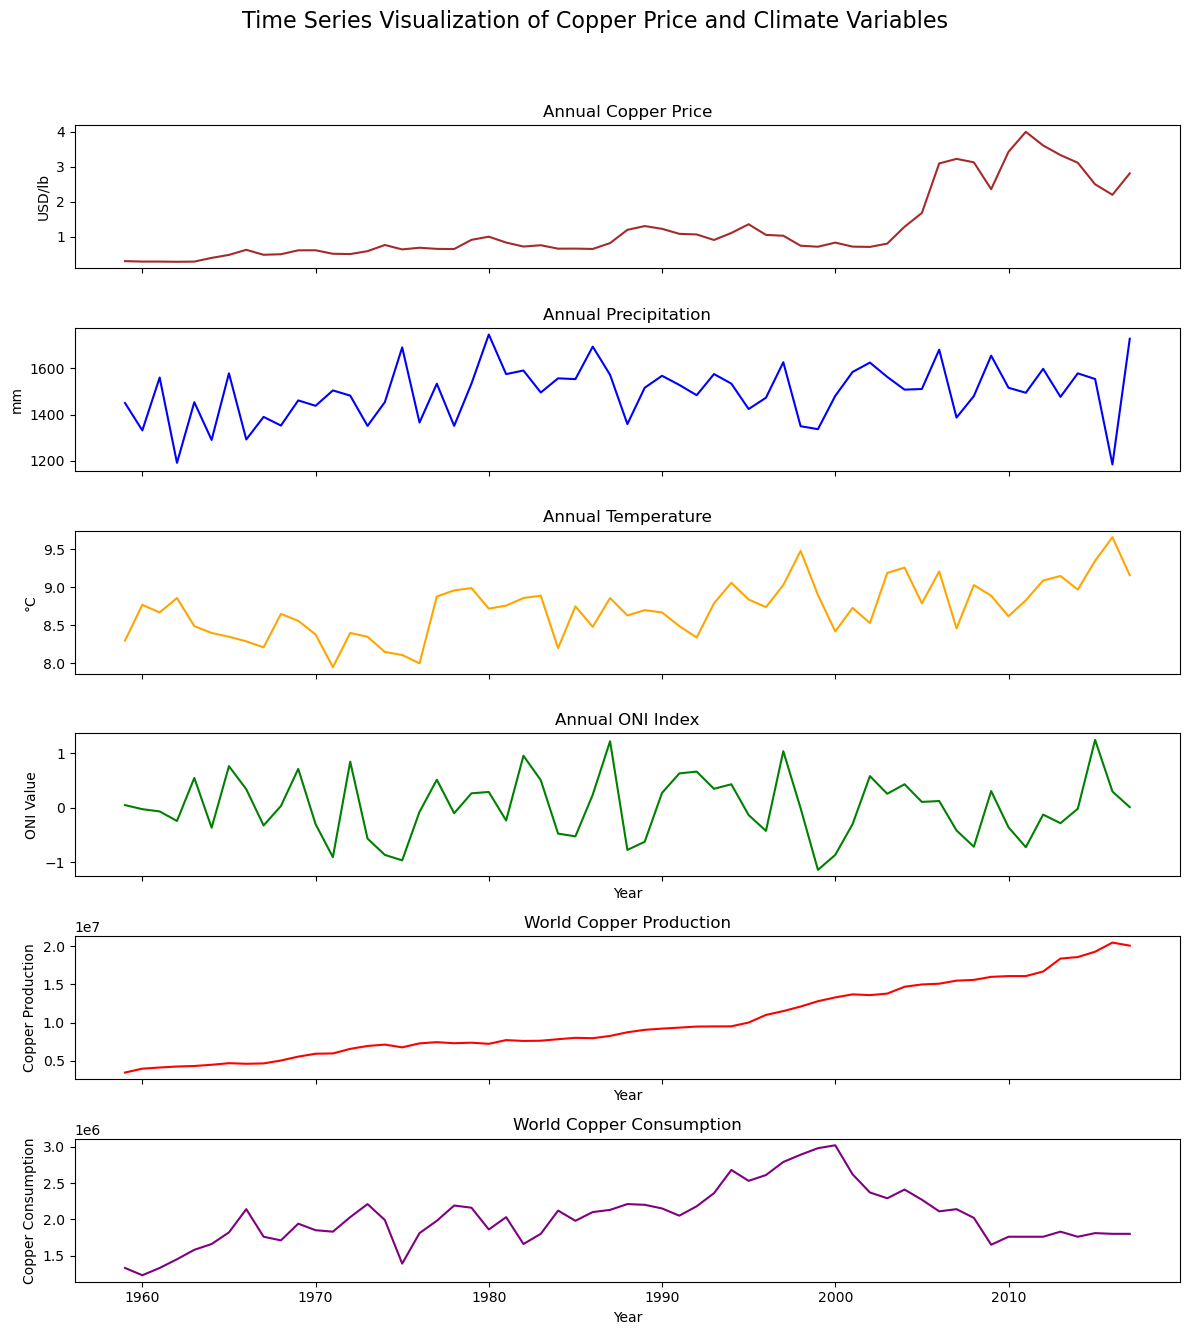

In [100]:
# Time Series Plots for Each Variable Separately
fig, axes = plt.subplots(6, 1, figsize=(12, 14), sharex=True)
fig.suptitle('Time Series Visualization of Copper Price and Climate Variables', fontsize=16)

# Copper Price
axes[0].plot(df_corrected_sorted['Year'], df_corrected_sorted['Copper_Price'], color='brown')
axes[0].set_title('Annual Copper Price')
axes[0].set_ylabel('USD/lb')

# Precipitation
axes[1].plot(df_corrected_sorted['Year'], df_corrected_sorted['Precipitation'], color='blue')
axes[1].set_title('Annual Precipitation')
axes[1].set_ylabel('mm')

# Temperature
axes[2].plot(df_corrected_sorted['Year'], df_corrected_sorted['Temperature'], color='orange')
axes[2].set_title('Annual Temperature')
axes[2].set_ylabel('°C')

# ONI Index
axes[3].plot(df_corrected_sorted['Year'], df_corrected_sorted['ONI'], color='green')
axes[3].set_title('Annual ONI Index')
axes[3].set_ylabel('ONI Value')
axes[3].set_xlabel('Year')

# World Copper Production
axes[4].plot(alldata['Year'], alldata['World production'], color='red')
axes[4].set_title('World Copper Production')
axes[4].set_ylabel('Copper Production')
axes[4].set_xlabel('Year')

# World Copper Demand
axes[5].plot(alldata['Year'], alldata['Consumption'], color='purple')
axes[5].set_title('World Copper Consumption')
axes[5].set_ylabel('Copper Consumption')
axes[5].set_xlabel('Year')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### IIIC: Raw Regression Analysis

##### Correlation Matrix of all variables:

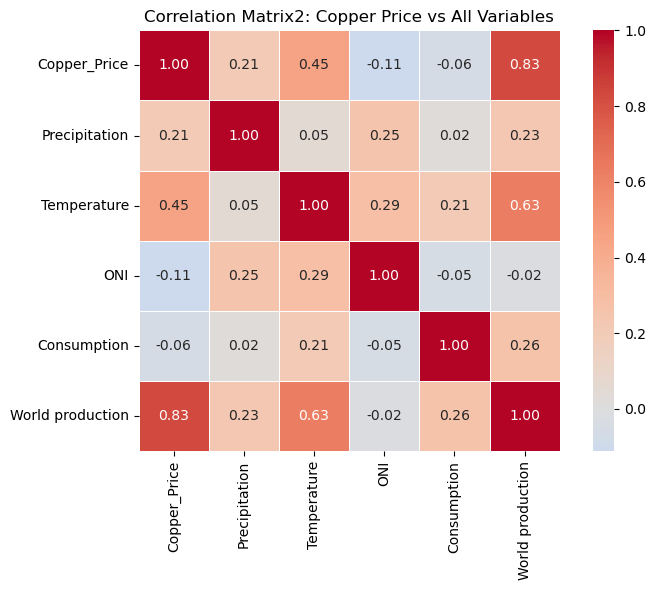

,Copper_Price,Precipitation,Temperature,ONI,Consumption,World production
Copper_Price,1.000000,0.210334,0.446756,-0.111790,-0.057025,0.826324
Precipitation,0.210334,1.000000,0.053673,0.254832,0.020329,0.231651
Temperature,0.446756,0.053673,1.000000,0.285612,0.212542,0.626955
ONI,-0.111790,0.254832,0.285612,1.000000,-0.050061,-0.017767
Consumption,-0.057025,0.020329,0.212542,-0.050061,1.000000,0.263727
World production,0.826324,0.231651,0.626955,-0.017767,0.263727,1.000000


In [101]:
corr_matrix2 = alldata[['Copper_Price', 'Precipitation', 'Temperature', 'ONI', 'Consumption', 'World production']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5, square=True)
plt.title('Correlation Matrix2: Copper Price vs All Variables')
plt.tight_layout()
plt.show()
corr_matrix2

##### Raw 1: Copper price on climate variables

In [102]:
X_all = df_corrected_sorted[['Precipitation', 'Temperature', 'ONI']]
X_all = sm.add_constant(X_all)
y_all = df_corrected_sorted['Copper_Price']
model_all = sm.OLS(y_all, X_all).fit()
print("\n--- Regression: Copper Price ~ Precip + Temp + ONI ---")
print(model_all.summary())


--- Regression: Copper Price ~ Precip + Temp + ONI ---
                            OLS Regression Results                            
Dep. Variable:           Copper_Price   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     8.957
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           6.31e-05
Time:                        01:06:20   Log-Likelihood:                -71.476
No. Observations:                  59   AIC:                             151.0
Df Residuals:                      55   BIC:                             159.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### Raw 2: World Copper Production on Climate variables in Chile

In [103]:
X_climate = alldata[['Precipitation', 'Temperature', 'ONI']]
X_climate = sm.add_constant(X_climate)
y_prod = alldata['World production']
model3 = sm.OLS(y_prod, X_climate).fit()
print("\n--- Regression: Copper Production ~ Precip + Temp + ONI---")
print(model3.summary())


--- Regression: Copper Production ~ Precip + Temp + ONI---
                            OLS Regression Results                            
Dep. Variable:       World production   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     18.46
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           2.07e-08
Time:                        01:06:23   Log-Likelihood:                -969.32
No. Observations:                  59   AIC:                             1947.
Df Residuals:                      55   BIC:                             1955.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

##### Raw 3: Copper Demand on Climate Variables

In [104]:
y_demand = alldata['Consumption']
model4 = sm.OLS(y_demand, X_climate).fit()
print("\n--- Regression: Copper Demand ~ Precip + Temp + ONI---")
print(model4.summary())


--- Regression: Copper Demand ~ Precip + Temp + ONI---
                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.171
Date:                Tue, 08 Jul 2025   Prob (F-statistic):              0.329
Time:                        01:06:26   Log-Likelihood:                -842.14
No. Observations:                  59   AIC:                             1692.
Df Residuals:                      55   BIC:                             1701.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### Raw 4: Copper price on all variables (including both climate and industrial variables)

In [105]:
X_all2 = alldata[['Precipitation', 'Temperature', 'ONI', 'Consumption', 'World production']]
X_all2 = sm.add_constant(X_all2)
y_all2 = alldata['Copper_Price']
model_all2 = sm.OLS(y_all2, X_all2).fit()
print("\n--- Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production---")
print(model_all2.summary())


--- Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production---
                            OLS Regression Results                            
Dep. Variable:           Copper_Price   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     37.23
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           3.50e-16
Time:                        01:06:29   Log-Likelihood:                -38.763
No. Observations:                  59   AIC:                             89.53
Df Residuals:                      53   BIC:                             102.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

##### Visualize the regression relationship between copper production and each climate variable

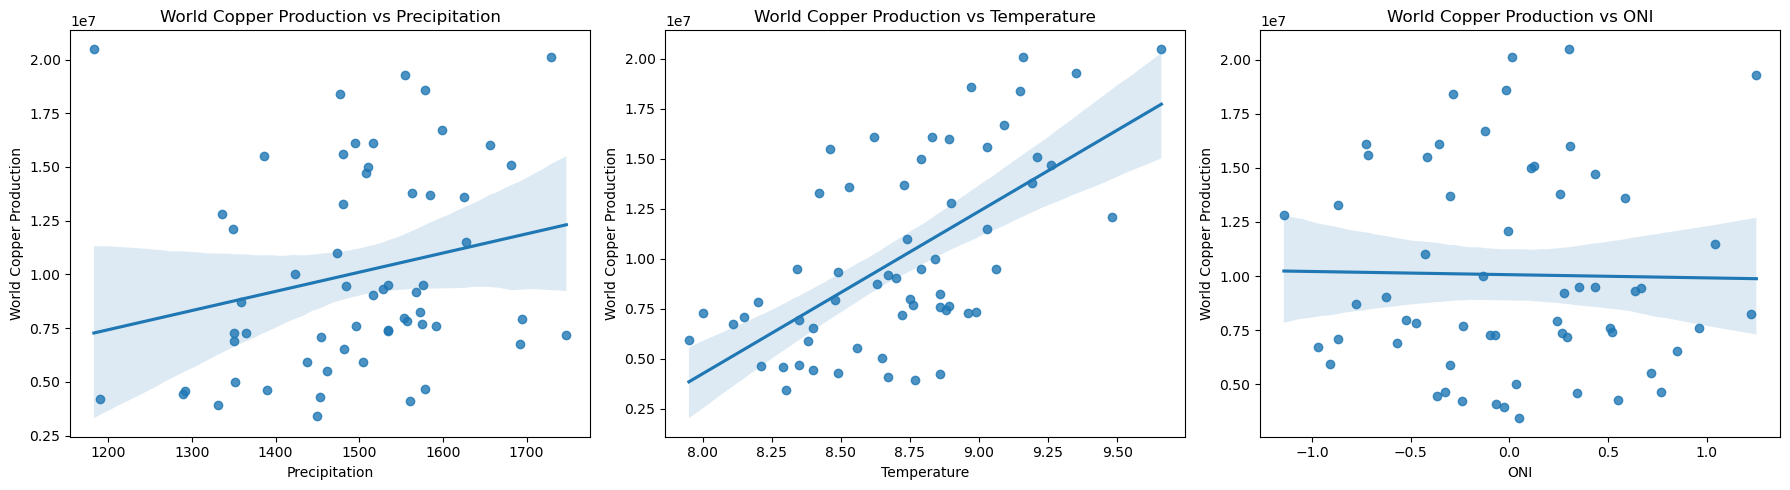

In [106]:
variables = ['Precipitation', 'Temperature', 'ONI']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, var in enumerate(variables):
    sns.regplot(x=var, y='World production', data=alldata, ax=axes[idx])
    axes[idx].set_title(f'World Copper Production vs {var}')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('World Copper Production')
plt.tight_layout()
plt.show()

#### IIID: Detrending Analysis

In [107]:
from scipy.signal import detrend
# Step 1: Detrend the variables
detrended_data = alldata.copy()
variables_to_detrend = ['Copper_Price', 'Precipitation', 'Temperature', 'ONI', 'World production', 'Consumption']

In [ ]:
for var in variables_to_detrend:
    detrended_data[f'{var}_detrended'] = detrend(detrended_data[var].values)

##### Detrended 1: Copper Price on climate variables

In [109]:
X_detrend_climate = detrended_data[['Precipitation_detrended', 'Temperature_detrended', 'ONI_detrended']]
X_detrend_climate = sm.add_constant(X_detrend_climate)
y_detrend_copper_price = detrended_data['Copper_Price_detrended']
model_detrend1 = sm.OLS(y_detrend_copper_price, X_detrend_climate).fit()
print("\n--- Detrended Regression: Copper Price ~ Precip + Temp + ONI ---")
print(model_detrend1.summary())


--- Detrended Regression: Copper Price ~ Precip + Temp + ONI ---
                              OLS Regression Results                              
Dep. Variable:     Copper_Price_detrended   R-squared:                       0.034
Model:                                OLS   Adj. R-squared:                 -0.019
Method:                     Least Squares   F-statistic:                    0.6368
Date:                    Tue, 08 Jul 2025   Prob (F-statistic):              0.595
Time:                            01:14:27   Log-Likelihood:                -52.689
No. Observations:                      59   AIC:                             113.4
Df Residuals:                          55   BIC:                             121.7
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------

##### Detrended 2: World Copper Production on Climate variables in Chile

In [110]:
y_detrend_production = detrended_data['World production_detrended']
model_detrend2 = sm.OLS(y_detrend_production, X_detrend_climate).fit()
print("\n--- Detrended Regression: Copper Production ~ Precip + Temp + ONI ---")
print(model_detrend2.summary())


--- Detrended Regression: Copper Production ~ Precip + Temp + ONI ---
                                OLS Regression Results                                
Dep. Variable:     World production_detrended   R-squared:                       0.089
Model:                                    OLS   Adj. R-squared:                  0.039
Method:                         Least Squares   F-statistic:                     1.785
Date:                        Tue, 08 Jul 2025   Prob (F-statistic):              0.161
Time:                                01:15:39   Log-Likelihood:                -901.84
No. Observations:                          59   AIC:                             1812.
Df Residuals:                              55   BIC:                             1820.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                              coef    std err          t   

##### Detrended 3: Demand on Climate Variables

In [112]:
y_detrend_demand = detrended_data['Consumption_detrended']
model_detrend3 = sm.OLS(y_detrend_demand, X_detrend_climate).fit()
print("\n--- Detrended Regression: Copper Demand ~ Precip + Temp + ONI ---")
print(model_detrend3.summary())


--- Detrended Regression: Copper Demand ~ Precip + Temp + ONI ---
                              OLS Regression Results                             
Dep. Variable:     Consumption_detrended   R-squared:                       0.016
Model:                               OLS   Adj. R-squared:                 -0.038
Method:                    Least Squares   F-statistic:                    0.3006
Date:                   Tue, 08 Jul 2025   Prob (F-statistic):              0.825
Time:                           01:16:23   Log-Likelihood:                -838.58
No. Observations:                     59   AIC:                             1685.
Df Residuals:                         55   BIC:                             1693.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------

##### Detrended 4: Copper Price on All variables

In [113]:
X_detrend_all = detrended_data[['Precipitation_detrended', 'Temperature_detrended', 'ONI_detrended',
                               'Consumption_detrended', 'World production_detrended']]
X_detrend_all = sm.add_constant(X_detrend_all)
model_detrend4 = sm.OLS(y_detrend_copper_price, X_detrend_all).fit()
print("\n--- Detrended Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production ---")
print(model_detrend4.summary())


--- Detrended Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production ---
                              OLS Regression Results                              
Dep. Variable:     Copper_Price_detrended   R-squared:                       0.493
Model:                                OLS   Adj. R-squared:                  0.445
Method:                     Least Squares   F-statistic:                     10.29
Date:                    Tue, 08 Jul 2025   Prob (F-statistic):           6.24e-07
Time:                            01:17:09   Log-Likelihood:                -33.680
No. Observations:                      59   AIC:                             79.36
Df Residuals:                          53   BIC:                             91.82
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [

##### Detrended Visualization

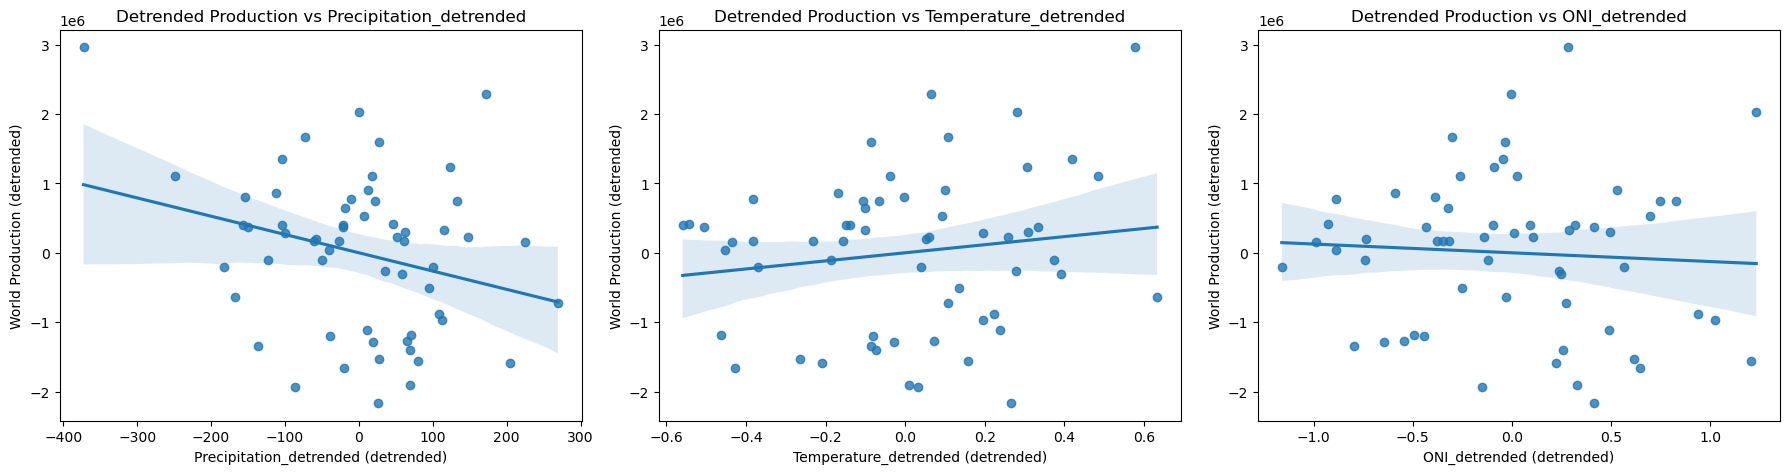

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, var in enumerate(['Precipitation_detrended', 'Temperature_detrended', 'ONI_detrended']):
    sns.regplot(x=var, y='World production_detrended', data=detrended_data, ax=axes[idx])
    axes[idx].set_title(f'Detrended Production vs {var}')
    axes[idx].set_xlabel(f'{var} (detrended)')
    axes[idx].set_ylabel('World Production (detrended)')

plt.tight_layout()
plt.show()

### IV. SSP Scenario Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Excel file from GitHub using openpyxl
url = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/Daily%20Copper%20Price.xlsx"
df = pd.read_excel(url, engine='openpyxl')

# 2. Show column names to verify structure
print("Columns in Excel file:")
print(df.columns)

# 3. Try to identify the copper price column
possible_price_columns = ['Price_USD_per_tonne', 'Price', 'Copper Price', 'Daily Price', 'Value']

price_col = None
for col in df.columns:
    if col in possible_price_columns:
        price_col = col
        break

if price_col is None:
    raise ValueError("Could not identify the column for copper price. Please check the Excel file.")

# 4. Convert dates and clean data
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date', price_col])

# 5. Group by year and calculate average
df['Year'] = df['Date'].dt.year
annual = df.groupby('Year')[price_col].mean().reset_index()

# 6. Get base year and price
base_year = annual['Year'].max()
base_price = annual.loc[annual['Year'] == base_year, price_col].values[0]
print(f"\nBase price for {base_year}: {base_price:.2f} USD/tonne")

# 7. Define SSP scenario growth rates
scenarios = {
    'SSP1 (sustainable)': 0.03,
    'SSP2 (middle)': 0.04,
    'SSP5 (fossil-driven)': 0.05
}

# 8. Project copper prices till 2050
years = np.arange(base_year, 2051)
proj = {
    name: base_price * (1 + rate) ** (years - base_year)
    for name, rate in scenarios.items()
}
df_proj = pd.DataFrame(proj, index=years)

# 9. Plot results
plt.figure(figsize=(10, 6))
for name in df_proj.columns:
    plt.plot(df_proj.index, df_proj[name], label=name)
plt.title(f'Copper Price Scenarios from {base_year} to 2050')
plt.xlabel('Year')
plt.ylabel('Price (USD/tonne)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.